In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import yfinance as yf
import tensorflow as tf
from pandas_datareader.yahoo.daily import YahooDailyReader
from stockstats import StockDataFrame
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Define the list of stock tickers and the date range
stock_tickers = ['OXY']#, 'GOOGL', 'MSFT']  # Replace with your list of stock tickers
start_date = '1954-01-01'  # Replace with your desired start date
end_date = '2023-09-17'  # Replace with your desired end date
# end_date = datetime.today()


def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append([target[i+target_size]])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multinew_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []   

    # start_index = start_index + history_size
    start_index = -history_size
    if end_index is None:
        end_index = len(dataset) 

    for i in range(start_index, end_index-target_size):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    return np.array(data)

def prediction_plot(history, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction[0])

    plt.plot(num_in, np.array(history), label='History')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction)[0], 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [2]:
# # Loop over each stock ticker
# # for ticker in stock_tickers:
# # Download stock price data using yfinance

[*********************100%%**********************]  1 of 1 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

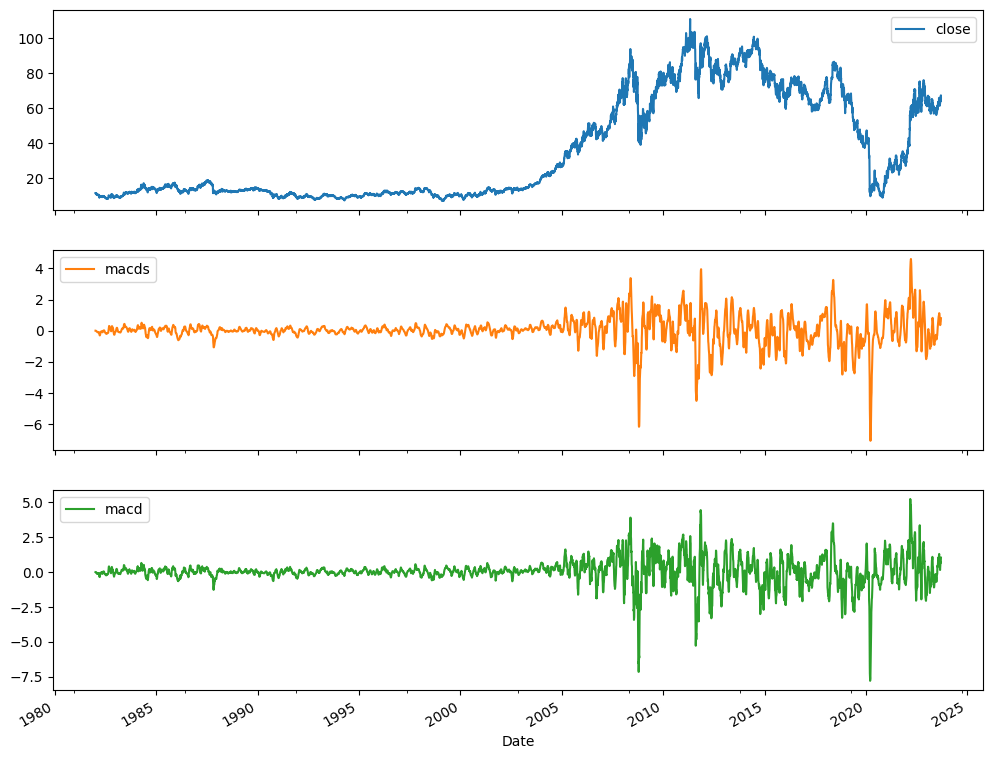

In [3]:
ticker = stock_tickers[0]

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
df = StockDataFrame.retype(df)
TRAIN_SPLIT = int(df.shape[0] * 0.8)
# df.head()

features_considered = ['close','macds','macd']
features = df[features_considered]
features.index = df.index
features.head()

features.plot(subplots=True,figsize=[12,10])

In [4]:
# Assuming your dataframe is called 'df' with columns 'column1', 'column2', 'column3'
columns_to_normalize = ['close', 'macds', 'macd']

# # Create an instance of MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler on the selected columns
# scaler.fit(features[columns_to_normalize])

# # Transform the selected columns using the scaler
# features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])

# dataset = features.values


dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std


pd.DataFrame(dataset, columns = features.columns, index = features.index).head()

,close,macds,macd
Date,,,
1981-12-31,-0.647973,-0.075882,-0.071262
1982-01-04,-0.647973,-0.075882,-0.071262
1982-01-05,-0.654143,-0.079003,-0.078364
1982-01-06,-0.652086,-0.080634,-0.078664
1982-01-07,-0.652086,-0.081584,-0.078671


In [5]:
past_history = 20
future_target = 5
STEP = 1

# Hyperparameters
BATCH_SIZE = 32
BUFFER_SIZE = 2000



x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)



#train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
#train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

#val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
#val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target price to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(8392, 20, 3)
(8392, 1)
Single window of past history : (20, 3)
Target price to predict : (1,)


In [6]:
# for x, y in val_data_multi.take(1):
#     multi_step_plot(x[0], y[0], np.array([0]))

In [7]:
# LSTM Parameters
EVALUATION_INTERVAL = 30 #len(x_train_multi)//batch_size//2 #15
VALIDATION_INTERVAL = 30 #len(x_val_multi)//batch_size//2
EPOCHS = 50
PATIENCE = 5

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)

In [8]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          recurrent_dropout=0.3,
                                          input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.Dropout(0.4))
multi_step_model.add(Dense(16))

multi_step_model.add(tf.keras.layers.LSTM(16,recurrent_dropout=0.3))
# multi_step_model.add(tf.keras.layers.Dropout(0.4))
multi_step_model.add(Dense(8))

multi_step_model.add(Dense(1,activation='linear'))



multi_step_model.compile(optimizer=tf.keras.optimizers.legacy.Nadam(learning_rate=0.001),loss='mae', metrics='accuracy')
print(multi_step_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4608      
                                                                 
 dense (Dense)               (None, 20, 16)            528       
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7393 (28.88 KB)
Trainable params: 7393 (28.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
multi_step_history = multi_step_model.fit(x_train_multi,y_train_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=(x_val_multi,y_val_multi),
                                          validation_steps=VALIDATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/50


2023-10-08 19:42:16.735250: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



30/30 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.0000e+00

2023-10-08 19:42:25.290130: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



30/30 [==============================] - 9s 87ms/step - loss: 0.4137 - accuracy: 0.0000e+00 - val_loss: 0.3017 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 2s 71ms/step - loss: 0.0838 - accuracy: 0.0000e+00 - val_loss: 0.1642 - val_accuracy: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 2s 74ms/step - loss: 0.0651 - accuracy: 0.0000e+00 - val_loss: 0.1693 - val_accuracy: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 2s 81ms/step - loss: 0.0617 - accuracy: 0.0000e+00 - val_loss: 0.1548 - val_accuracy: 0.0000e+00
Epoch 5/50
30/30 [==============================] - 2s 78ms/step - loss: 0.0586 - accuracy: 0.0000e+00 - val_loss: 0.1399 - val_accuracy: 0.0000e+00
Epoch 6/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0532 - accuracy: 0.0000e+00 - val_loss: 0.1375 - val_accuracy: 0.0000e+00
Epoch 7/50
30/30 [==============================] - 2s 74ms/step - loss: 0.0541 - accuracy: 0.0000e+00 - val_loss: 0.

In [10]:
# plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

<Axes: title={'center': 'Accuracy'}>

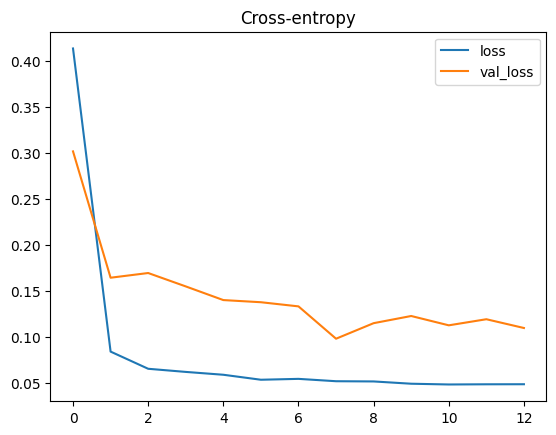

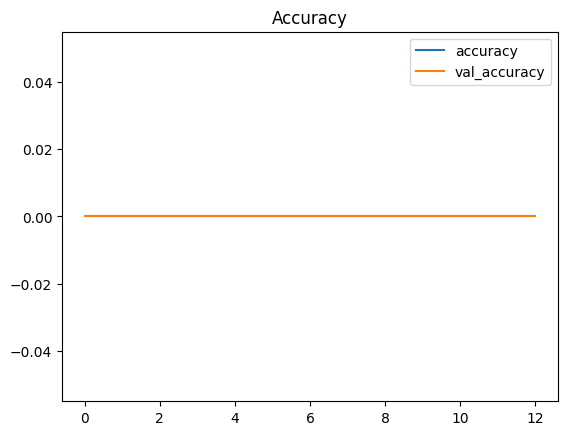

In [11]:
history_df = pd.DataFrame(multi_step_history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

2023-10-08 19:42:53.708469: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 
2023-10-08 19:42:53.759379: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 1s 625ms/step


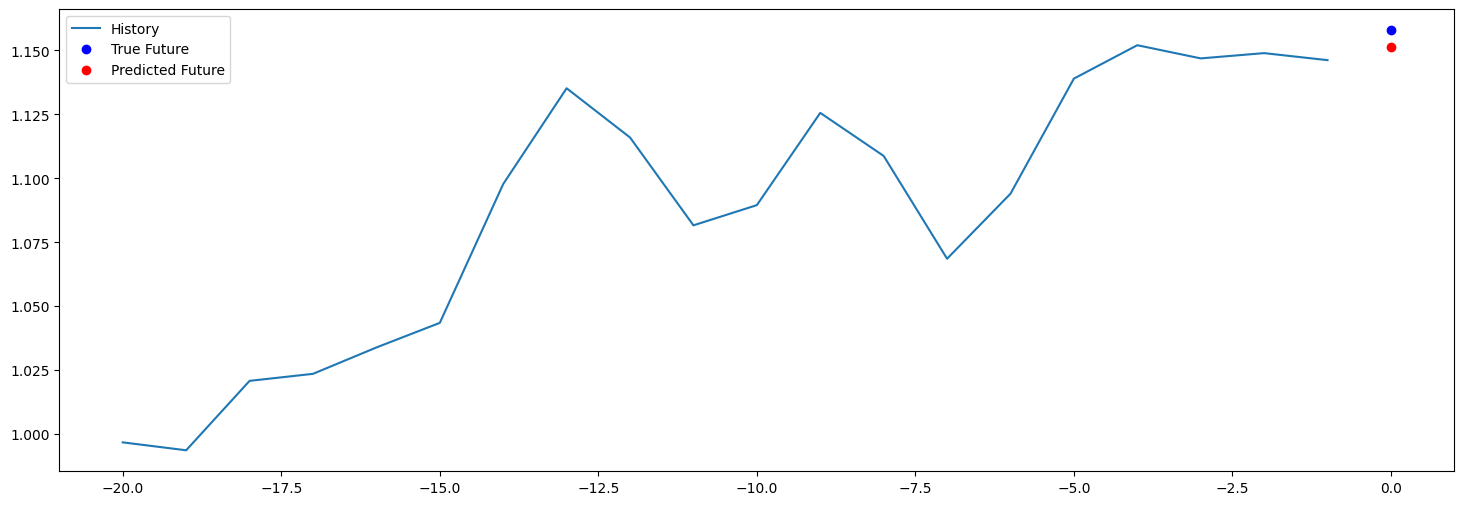

In [12]:
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)

x_val_multi = x_val_multi[-20:]
y_val_multi = y_val_multi[-20:]

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

for x, y in val_data_multi.take(1):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])


In [13]:
x_new_multi = multinew_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

x_new_multi = x_new_multi[-20:]



predictions_0 = multi_step_model.predict(x_new_multi[0:1])
predictions_1 = multi_step_model.predict(x_new_multi[-1:])#[0]


predictions_0, predictions_1
# np.shape(x_new_multi)
# x_new_multi[0:1],x_new_multi[-1:]

2023-10-08 19:42:54.926748: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 0s 32ms/step


2023-10-08 19:42:55.579125: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



(array([[1.1511741]], dtype=float32), array([[1.2256683]], dtype=float32))

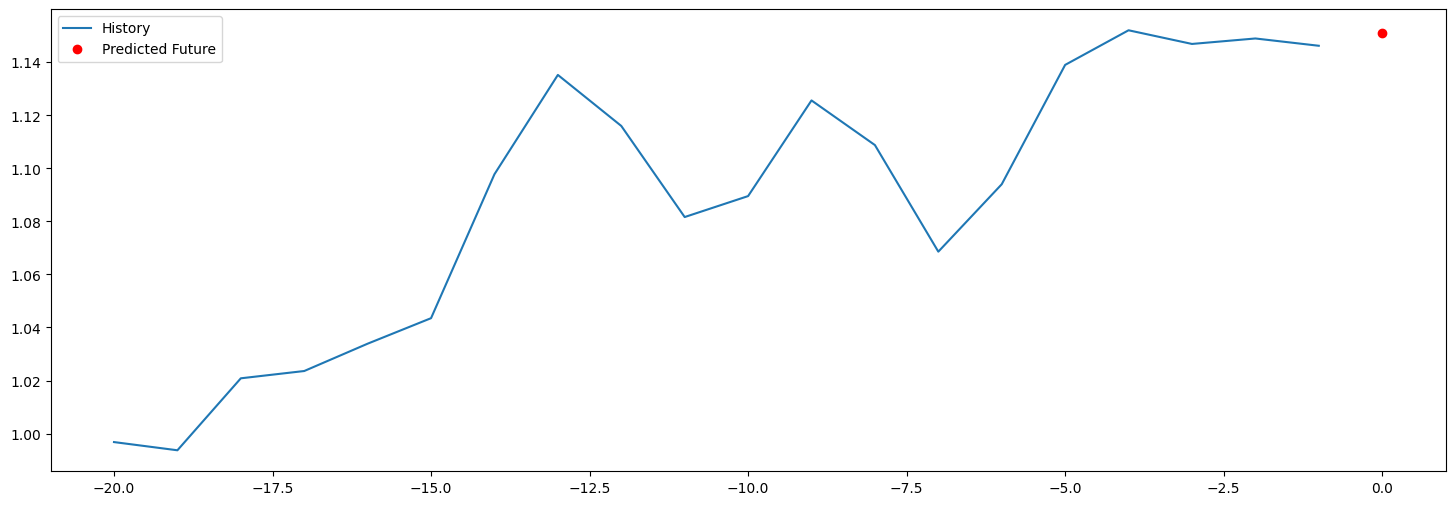

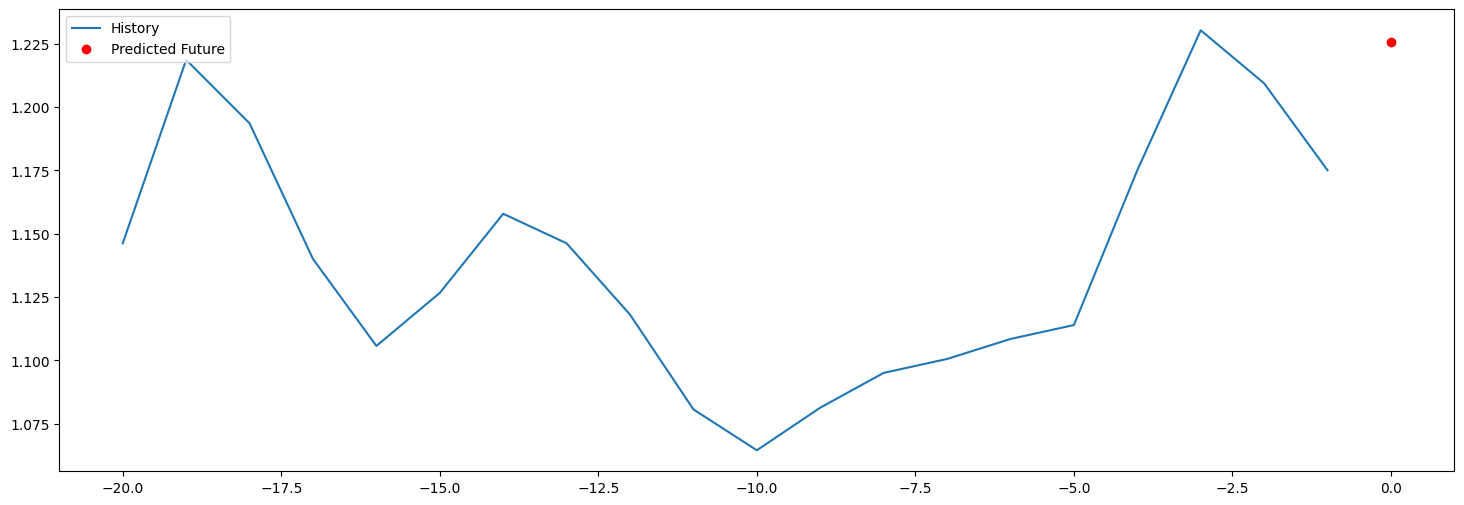

In [14]:
# New Predictions
prediction_plot(x_new_multi[0][:,0], predictions_0)
prediction_plot(x_new_multi[-1][:,0], predictions_1)

In [15]:
#  multi_step_model.save(f"model/model_{ticker}.h5")